# Overfitting Testing Notebook

This notebook is dedicated to testing and analyzing overfitting in the movie genre classification model.

## Features:
- Train models with different regularization levels
- Compare train vs test performance across different configurations
- Visualize overfitting metrics and learning curves
- Test different regularization strategies (L1, L2, ElasticNet)
- Analyze performance across different training set sizes
- Test TruncatedSVD dimensionality reduction to reduce overfitting
- Identify optimal regularization parameters to minimize overfitting

In [1]:
# Import required libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, learning_curve, 
    validation_curve, cross_val_score, KFold)

from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    hamming_loss, jaccard_score, make_scorer
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
import time
from typing import Dict, List, Tuple, Any
import json

# Project imports
from descriptions.config import INTERIM_DATA_DIR, MODELS_DIR
from descriptions.dataset import load_interim

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✓ All imports successful")

2025-12-09 18:50:06.055 | INFO     | descriptions.config:<module>:11 - PROJ_ROOT path is: /Users/christianfullerton/Developer/Python Workspace/movie_genre_model


✓ All imports successful


## 1. Load and Prepare Data

In [2]:
# Load and prepare data
print("Loading data...")
data = load_interim(INTERIM_DATA_DIR / "cleaned_movies.csv")
print(f"✓ Loaded {len(data)} samples")
print(f"Columns: {list(data.columns)}")

# Split data into train and test sets BEFORE preprocessing (prevents data leakage)
RANDOM_STATE = 42
TEST_SIZE = 0.2
X_text, y_genres = data['description'], data['genre']

print("\nSplitting data...")
X_train_text, X_test_text, y_train_genres, y_test_genres = train_test_split(
    X_text, y_genres, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(f"✓ Data split complete: {len(X_train_text)} training samples, {len(X_test_text)} test samples")

Loading data...
2025-12-09 18:50:06.119 | INFO     | descriptions.dataset:load_interim:99 - Loading interim data from /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/data/interim/cleaned_movies.csv...
2025-12-09 18:50:06.207 | DEBUG    | descriptions.dataset:load_interim:103 - Loaded with index column
2025-12-09 18:50:06.207 | SUCCESS  | descriptions.dataset:load_interim:108 - ✓ Data loaded successfully: 9087 rows, 2 columns
✓ Loaded 9087 samples
Columns: ['genre', 'description']

Splitting data...
✓ Data split complete: 7269 training samples, 1818 test samples


## 2. Evaluation Function

Helper function to evaluate models and calculate metrics.

In [3]:
# Get unique genres for exploration (from all data)
unique_genres = set(y_genres.str.split(",").explode().unique())
print(f"Total unique genres found: {len(unique_genres)}")
print(f"Genres: {unique_genres}")

Total unique genres found: 37
Genres: {'Music', 'Western', ' TV Movie', ' Family', ' Comedy', 'Thriller', 'Mystery', 'Family', ' War', ' Drama', ' Horror', 'Drama', 'Romance', 'History', nan, 'TV Movie', ' Crime', 'Comedy', ' Action', ' Fantasy', ' Romance', ' Science Fiction', ' Thriller', 'Fantasy', 'Action', 'Science Fiction', 'Horror', ' Mystery', ' Western', ' History', 'Adventure', ' Animation', ' Music', 'Crime', 'Animation', 'War', ' Adventure'}


## 3. Preprocess Data

Preprocess genres and generate TF-IDF features for training.

In [4]:
# Preprocess genres: convert comma-separated strings to lists
print("Preprocessing genres...")

# Training genres
y_train_genres_list = y_train_genres.fillna("").astype(str).str.strip()
y_train_genres_list = y_train_genres_list.str.split(r"\s*,\s*").apply(
    lambda genres: sorted({g.strip() for g in genres if g.strip()})
)

# Test genres
y_test_genres_list = y_test_genres.fillna("").astype(str).str.strip()
y_test_genres_list = y_test_genres_list.str.split(r"\s*,\s*").apply(
    lambda genres: sorted({g.strip() for g in genres if g.strip()})
)

# Step 1: Analyze genre frequencies to identify rare genres
print("\nAnalyzing genre frequencies...")
mlb_temp = MultiLabelBinarizer()
y_train_binary_temp = mlb_temp.fit_transform(y_train_genres_list)

# Calculate genre frequencies and percentages
genre_counts = y_train_binary_temp.sum(axis=0)
genre_percentages = (genre_counts / len(y_train_binary_temp)) * 100

# Identify genres to remove (< 5%)
MIN_PERCENTAGE = 5.0
genres_to_remove = set()
for i, (genre, percentage) in enumerate(zip(mlb_temp.classes_, genre_percentages)):
    if percentage < MIN_PERCENTAGE:
        genres_to_remove.add(genre)
        print(f"  Removing '{genre}': {percentage:.2f}% ({int(genre_counts[i])} samples)")

print(f"\n✓ Identified {len(genres_to_remove)} genres to remove (< {MIN_PERCENTAGE}%)")

# Step 2: Filter out rare genres from genre lists
print("\nFiltering out rare genres from genre lists...")
y_train_genres_filtered = y_train_genres_list.apply(
    lambda genres: sorted({g for g in genres if g not in genres_to_remove})
)
y_test_genres_filtered = y_test_genres_list.apply(
    lambda genres: sorted({g for g in genres if g not in genres_to_remove})
)

# Count how many samples lost all genres
train_samples_lost = (y_train_genres_filtered.apply(len) == 0).sum()
test_samples_lost = (y_test_genres_filtered.apply(len) == 0).sum()

if train_samples_lost > 0 or test_samples_lost > 0:
    print(f"  ⚠️  Warning: {train_samples_lost} training samples and {test_samples_lost} test samples lost all genres")
    print(f"  These samples will be removed from the dataset")

# Remove samples that have no genres left
if train_samples_lost > 0:
    keep_train_mask = y_train_genres_filtered.apply(len) > 0
    y_train_genres_filtered = y_train_genres_filtered[keep_train_mask]
    X_train_text = X_train_text[keep_train_mask]
    print(f"  Removed {train_samples_lost} training samples with no genres")

if test_samples_lost > 0:
    keep_test_mask = y_test_genres_filtered.apply(len) > 0
    y_test_genres_filtered = y_test_genres_filtered[keep_test_mask]
    X_test_text = X_test_text[keep_test_mask]
    print(f"  Removed {test_samples_lost} test samples with no genres")

# Step 3: Fit MultiLabelBinarizer on filtered training data
print("\nFitting MultiLabelBinarizer on filtered training data...")
mlb = MultiLabelBinarizer()
y_train_binary = mlb.fit_transform(y_train_genres_filtered)
y_test_binary = mlb.transform(y_test_genres_filtered)  # Transform test data

print(f"✓ Binary labels created:")
print(f"  Training: {y_train_binary.shape[0]} samples × {y_train_binary.shape[1]} labels")
print(f"  Test: {y_test_binary.shape[0]} samples × {y_test_binary.shape[1]} labels")
print(f"  Unique genres: {len(mlb.classes_)}")
print(f"  Genres kept: {list(mlb.classes_)}")

# Show updated genre distribution
print("\nUpdated genre distribution:")
genre_counts_new = y_train_binary.sum(axis=0)
genre_percentages_new = (genre_counts_new / len(y_train_binary)) * 100
for genre, count, pct in zip(mlb.classes_, genre_counts_new, genre_percentages_new):
    print(f"  {genre:20s}: {count:5d} samples ({pct:5.2f}%)")

# Calculate new imbalance ratio
max_count_new = genre_counts_new.max()
min_count_new = genre_counts_new.min()
imbalance_ratio_new = max_count_new / min_count_new if min_count_new > 0 else float('inf')
print(f"\n  New imbalance ratio: {imbalance_ratio_new:.1f}x (was 43.4x)")

# Generate TF-IDF features
print("\nGenerating TF-IDF features...")
vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words="english",
    ngram_range=(1, 2),
    sublinear_tf=True,
    max_df=0.7,
    min_df=3,
    use_idf=True
)

X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

print(f"✓ TF-IDF features created:")
print(f"  Training: {X_train_tfidf.shape[0]} samples × {X_train_tfidf.shape[1]} features")
print(f"  Test: {X_test_tfidf.shape[0]} samples × {X_test_tfidf.shape[1]} features")


Preprocessing genres...

Analyzing genre frequencies...
  Removing 'Music': 2.92% (212 samples)
  Removing 'TV Movie': 1.09% (79 samples)
  Removing 'War': 3.44% (250 samples)
  Removing 'Western': 1.40% (102 samples)

✓ Identified 4 genres to remove (< 5.0%)

Filtering out rare genres from genre lists...
  ⚠️  Warning: 16 training samples and 11 test samples lost all genres
  These samples will be removed from the dataset
  Removed 16 training samples with no genres
  Removed 11 test samples with no genres

Fitting MultiLabelBinarizer on filtered training data...
✓ Binary labels created:
  Training: 7253 samples × 14 labels
  Test: 1807 samples × 14 labels
  Unique genres: 14
  Genres kept: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Mystery', 'Romance', 'Science Fiction', 'Thriller']

Updated genre distribution:
  Action              :  1663 samples (22.93%)
  Adventure           :  1204 samples (16.60%)
  Animation     

## 3.5. Feature Selection with SelectKBest

Select the most informative features to reduce overfitting and improve generalization.

In [5]:

print("Applying feature selection with SelectKBest...")
K_FEATURES = 4500  
feature_selector = SelectKBest(score_func=chi2, k=K_FEATURES)

# Fit on training data and transform both train and test
# IMPORTANT: Fit only on training data to prevent data leakage
X_train_selected = feature_selector.fit_transform(X_train_tfidf, y_train_binary)
X_test_selected = feature_selector.transform(X_test_tfidf)

print(f"✓ Feature selection complete:")
print(f"  Original features: {X_train_tfidf.shape[1]}")
print(f"  Selected features: {X_train_selected.shape[1]}")
print(f"  Features removed: {X_train_tfidf.shape[1] - X_train_selected.shape[1]}")
print(f"  Reduction: {(1 - X_train_selected.shape[1]/X_train_tfidf.shape[1])*100:.1f}%")
print(f"\n  Training: {X_train_selected.shape[0]} samples × {X_train_selected.shape[1]} features")
print(f"  Test: {X_test_selected.shape[0]} samples × {X_test_selected.shape[1]} features")

# Note: Use X_train_selected and X_test_selected for training instead of X_train_tfidf and X_test_tfidf


Applying feature selection with SelectKBest...
✓ Feature selection complete:
  Original features: 10000
  Selected features: 4500
  Features removed: 5500
  Reduction: 55.0%

  Training: 7253 samples × 4500 features
  Test: 1807 samples × 4500 features


## 4. Evaluation Function

Helper function to evaluate models and calculate metrics for overfitting analysis.

In [6]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate a model on both training and test sets.
    
    Returns a dictionary with train and test metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'train': {
            'f1_macro': f1_score(y_train, y_train_pred, average='macro', zero_division=0),
            'f1_micro': f1_score(y_train, y_train_pred, average='micro', zero_division=0),
            'precision_macro': precision_score(y_train, y_train_pred, average='macro', zero_division=0),
            'recall_macro': recall_score(y_train, y_train_pred, average='macro', zero_division=0),
            'hamming_loss': hamming_loss(y_train, y_train_pred),
            'jaccard_score': jaccard_score(y_train, y_train_pred, average='macro', zero_division=0)
        },
        'test': {
            'f1_macro': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
            'f1_micro': f1_score(y_test, y_test_pred, average='micro', zero_division=0),
            'precision_macro': precision_score(y_test, y_test_pred, average='macro', zero_division=0),
            'recall_macro': recall_score(y_test, y_test_pred, average='macro', zero_division=0),
            'hamming_loss': hamming_loss(y_test, y_test_pred),
            'jaccard_score': jaccard_score(y_test, y_test_pred, average='macro', zero_division=0)
        }
    }
    
    # Calculate overfitting gap (train - test)
    metrics['overfitting_gap'] = {
        'f1_macro': metrics['train']['f1_macro'] - metrics['test']['f1_macro'],
        'f1_micro': metrics['train']['f1_micro'] - metrics['test']['f1_micro'],
        'precision_macro': metrics['train']['precision_macro'] - metrics['test']['precision_macro'],
        'recall_macro': metrics['train']['recall_macro'] - metrics['test']['recall_macro'],
        'hamming_loss': metrics['test']['hamming_loss'] - metrics['train']['hamming_loss'],  # Lower is better
        'jaccard_score': metrics['train']['jaccard_score'] - metrics['test']['jaccard_score']
    }
    
    return metrics

print("✓ Evaluation function defined")

✓ Evaluation function defined


## 5. Test Different Alpha Values for Overfitting

Train models with varying regularization strength (alpha) to analyze overfitting.
Smaller alpha = less regularization = more overfitting risk.
Larger alpha = more regularization = less overfitting risk.

In [7]:
# Convert alpha values to C values (LogisticRegression uses C = 1/alpha)
# Test a range of C values (larger C = less regularization)
C_values = [1]

print(f"Testing {len(C_values)} different C values (LogisticRegression):")
print(f"C values: {C_values}\n")

# Create custom scorer for multi-label F1 macro
f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

# Setup cross-validation (5-fold)
cv_folds = 5
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Store results
results = []

for C in C_values:
    print(f"\nTraining LogisticRegression with C={C:.2f}...")
    start_time = time.time()
    
    # Create model with LogisticRegression
    model = OneVsRestClassifier(
        LogisticRegression(
            C=C,
            penalty='elasticnet',
            solver='saga',  # 'saga' supports elasticnet penalty
            l1_ratio=0.6,  # Balance between L1 and L2 (0.5 = equal mix)
            max_iter=1000,
            tol=1e-3,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    )
    
    # Perform cross-validation on training data
    print(f"  Performing {cv_folds}-fold cross-validation...")
    cv_scores = cross_val_score(
        model, 
        X_train_selected, 
        y_train_binary,
        cv=kfold,
        scoring=f1_macro_scorer,
        n_jobs=-1
    )
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    print(f"  CV F1 Macro: {cv_mean:.4f} (+/- {cv_std:.4f})")
    
    # Train on full training set
    model.fit(X_train_selected, y_train_binary)
    
    # Evaluate on test set
    metrics = evaluate_model(model, X_train_selected, X_test_selected, y_train_binary, y_test_binary)
    
    training_time = time.time() - start_time
    
    # Store results
    result = {
        'C': C,
        'cv_f1_macro_mean': cv_mean,
        'cv_f1_macro_std': cv_std,
        'cv_f1_macro_min': cv_scores.min(),
        'cv_f1_macro_max': cv_scores.max(),
        'train_f1_macro': metrics['train']['f1_macro'],
        'test_f1_macro': metrics['test']['f1_macro'],
        'train_f1_micro': metrics['train']['f1_micro'],
        'test_f1_micro': metrics['test']['f1_micro'],
        'train_hamming_loss': metrics['train']['hamming_loss'],
        'test_hamming_loss': metrics['test']['hamming_loss'],
        'overfitting_gap_f1_macro': metrics['overfitting_gap']['f1_macro'],
        'overfitting_gap_f1_micro': metrics['overfitting_gap']['f1_micro'],
        'training_time': training_time
    }
    results.append(result)
    print(f"  ✓ Completed in {training_time:.2f}s - Test F1 Macro: {metrics['test']['f1_macro']:.4f}")

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print("\n✓ C value testing with cross-validation complete!")
print(f"\nResults summary:")
display(results_df)

# Print best C based on CV score
best_cv_idx = results_df['cv_f1_macro_mean'].idxmax()
best_cv_C = results_df.loc[best_cv_idx, 'C']
print(f"\nBest C (highest CV F1 Macro): {best_cv_C:.2f}")
print(f"  CV F1 Macro: {results_df.loc[best_cv_idx, 'cv_f1_macro_mean']:.4f} (+/- {results_df.loc[best_cv_idx, 'cv_f1_macro_std']:.4f})")
print(f"  Test F1 Macro: {results_df.loc[best_cv_idx, 'test_f1_macro']:.4f}")

Testing 1 different C values (LogisticRegression):
C values: [1]


Training LogisticRegression with C=1.00...
  Performing 5-fold cross-validation...
  CV F1 Macro: 0.5380 (+/- 0.0173)
  ✓ Completed in 267.13s - Test F1 Macro: 0.5585

✓ C value testing with cross-validation complete!

Results summary:


,C,cv_f1_macro_mean,cv_f1_macro_std,cv_f1_macro_min,cv_f1_macro_max,train_f1_macro,test_f1_macro,train_f1_micro,test_f1_micro,train_hamming_loss,test_hamming_loss,overfitting_gap_f1_macro,overfitting_gap_f1_micro,training_time
0,1,0.537981,0.017295,0.510662,0.556313,0.699439,0.558508,0.712315,0.589485,0.122018,0.175627,0.140931,0.12283,267.12976



Best C (highest CV F1 Macro): 1.00
  CV F1 Macro: 0.5380 (+/- 0.0173)
  Test F1 Macro: 0.5585


## 6. Visualize Overfitting Analysis

Visualize how different alpha values affect train vs test performance and overfitting.

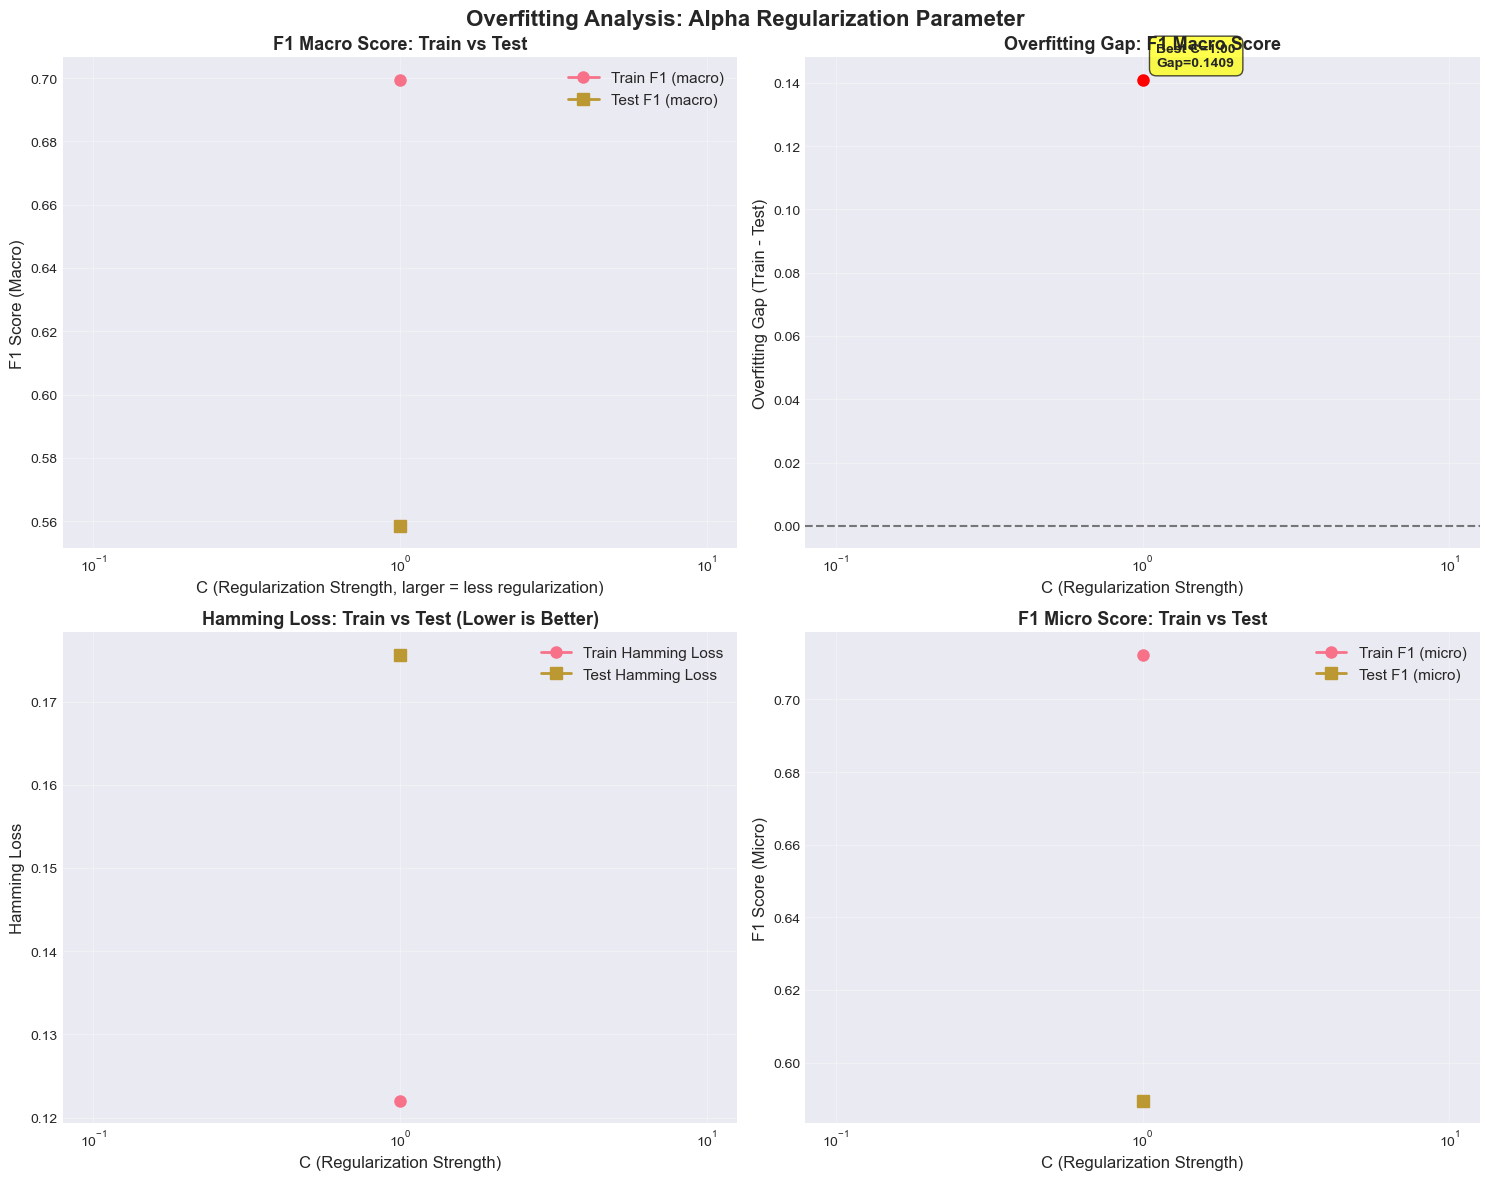


OVERFITTING ANALYSIS SUMMARY

Best C (smallest overfitting gap): 1.00
  Train F1 (macro): 0.6994
  Test F1 (macro): 0.5585
  Overfitting gap: 0.1409

Best C (highest test F1): 1.00
  Train F1 (macro): 0.6994
  Test F1 (macro): 0.5585
  Overfitting gap: 0.1409



In [8]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Overfitting Analysis: Alpha Regularization Parameter', fontsize=16, fontweight='bold')

# Plot 1: F1 Macro Score (Train vs Test)
ax1 = axes[0, 0]
ax1.plot(results_df['C'], results_df['train_f1_macro'], 'o-', label='Train F1 (macro)', linewidth=2, markersize=8)
ax1.plot(results_df['C'], results_df['test_f1_macro'], 's-', label='Test F1 (macro)', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('C (Regularization Strength, larger = less regularization)', fontsize=12)
ax1.set_ylabel('F1 Score (Macro)', fontsize=12)
ax1.set_title('F1 Macro Score: Train vs Test', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Overfitting Gap (F1 Macro)
ax2 = axes[0, 1]
ax2.plot(results_df['C'], results_df['overfitting_gap_f1_macro'], 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel('C (Regularization Strength)', fontsize=12)
ax2.set_ylabel('Overfitting Gap (Train - Test)', fontsize=12)
ax2.set_title('Overfitting Gap: F1 Macro Score', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
# Add annotation for best C (smallest gap)
best_alpha_idx = results_df['overfitting_gap_f1_macro'].abs().idxmin()
best_alpha = results_df.loc[best_alpha_idx, 'C']
best_gap = results_df.loc[best_alpha_idx, 'overfitting_gap_f1_macro']
ax2.annotate(f'Best C={best_alpha:.2f}\nGap={best_gap:.4f}', 
             xy=(best_alpha, best_gap), 
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             fontsize=10, fontweight='bold')

# Plot 3: Hamming Loss (Train vs Test)
ax3 = axes[1, 0]
ax3.plot(results_df['C'], results_df['train_hamming_loss'], 'o-', label='Train Hamming Loss', linewidth=2, markersize=8)
ax3.plot(results_df['C'], results_df['test_hamming_loss'], 's-', label='Test Hamming Loss', linewidth=2, markersize=8)
ax3.set_xscale('log')
ax3.set_xlabel('C (Regularization Strength)', fontsize=12)
ax3.set_ylabel('Hamming Loss', fontsize=12)
ax3.set_title('Hamming Loss: Train vs Test (Lower is Better)', fontsize=13, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: F1 Micro Score (Train vs Test)
ax4 = axes[1, 1]
ax4.plot(results_df['C'], results_df['train_f1_micro'], 'o-', label='Train F1 (micro)', linewidth=2, markersize=8)
ax4.plot(results_df['C'], results_df['test_f1_micro'], 's-', label='Test F1 (micro)', linewidth=2, markersize=8)
ax4.set_xscale('log')
ax4.set_xlabel('C (Regularization Strength)', fontsize=12)
ax4.set_ylabel('F1 Score (Micro)', fontsize=12)
ax4.set_title('F1 Micro Score: Train vs Test', fontsize=13, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("OVERFITTING ANALYSIS SUMMARY")
print("="*70)
print(f"\nBest C (smallest overfitting gap): {best_alpha:.2f}")
print(f"  Train F1 (macro): {results_df.loc[best_alpha_idx, 'train_f1_macro']:.4f}")
print(f"  Test F1 (macro): {results_df.loc[best_alpha_idx, 'test_f1_macro']:.4f}")
print(f"  Overfitting gap: {best_gap:.4f}")

# Find C with best test performance
best_test_idx = results_df['test_f1_macro'].idxmax()
best_test_alpha = results_df.loc[best_test_idx, 'C']
print(f"\nBest C (highest test F1): {best_test_alpha:.2f}")
print(f"  Train F1 (macro): {results_df.loc[best_test_idx, 'train_f1_macro']:.4f}")
print(f"  Test F1 (macro): {results_df.loc[best_test_idx, 'test_f1_macro']:.4f}")
print(f"  Overfitting gap: {results_df.loc[best_test_idx, 'overfitting_gap_f1_macro']:.4f}")

print("\n" + "="*70)